**Setup iniziale**

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import callbacks
from keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')
cwd= 'drive/MyDrive/Colab Notebooks'
file_path= cwd + '/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Carichiamo il dataset
# -> nrows indica il numero di righe massimo da caricare (qua ne carichiamo 300.000 per cercare di avere nel dataframe almeno 5 possibili classi di 'status')
# -> na_values contiene le stringhe del file che indicano valori assenti nelle celle (Pandas li sostituisce con un valore None)
df= pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA', 'n/a', 'ND',''], nrows=300000)

# LA COLONNA (o feature) 'status' È IL TARGET DA PREDIRE (ovvero la nostra Y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data cleaning**

In [ ]:
# Puliamo il dataframe

# La funzione dropna() usa questi parametri:
# -> "axis" indica: 0=righe / 1=colonne [default: '0']
# -> "how" indica: 'all'="se tutti i valori sono nulli" / 'any'="se almeno un valore è nullo" [default: 'any']
# -> "subset" indica di considerare solo i valori di certe colonne quando deve verificare se sono nulli
# -> "inplace=True" dice a Pandas di fare la modifica direttamente sull'oggetto (quindi le funzioni ritorneranno None)
df.dropna(axis=0, how='any', subset='status', inplace=True) # Eliminiamo tutte le righe che hanno un valore None nel campo 'status' (perché non sono classificabili)
df.dropna(axis=1, how='all', inplace=True) # Eliminiamo tutte le colonne che hanno tutti valori None (SOLO VALORI NULLI)

 # Sostituiamo i valori +inf e -inf con NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)#non è questo caso

# Selezioniamo i nomi delle colonne con valori puramente numerici (ci serviranno per dopo e soprattutto li usiamo anche qua nella sezione di data cleaning)
numeric_cols_names= df.select_dtypes(include=np.number).columns.tolist()
# Useremo "numeric_cols_names" come X, ma prima rimuoviamo 'aqi' perché è troppo correlata a 'status' (renderebbe la vita troppo facile al modello)
numeric_cols_names.remove('aqi')
numeric_cols_names.remove('siteid') # Rimuoviamo anche 'siteid' perché non è una feature necessaria alla predizione della classe di 'status'
# Dato che poi useremo le colonne numeriche come feature X (per ottenere la predizione), potremmo dover togliere la colonna target da "numeric_cols_names"
# Nel nostro caso non serve perché 'status' è categorica (stringa), non numerica
"""
if 'status' in numeric_cols_names:
    numeric_cols_names.remove('status')
"""

# Eliminiamo tutte le righe che hanno almeno un campo numerico (almeno una colonna tra quelle di "numeric_cols_names") con valore NaN
# QUESTO È IMPORTANTISSIMO PER IL CORRETTO ADDESTRAMENTO DELLA RETE NEURALE: NON FUNZIONA CON DEI NaN TRA I DATI DI TRAIN!
df.dropna(axis=0, how='any', subset=numeric_cols_names, inplace=True)

**Analisi del dataset**

Dobbiamo andare a vedere quante classi di 'status' abbiamo nel dataset perché quando creeremo il modello di rete neurale dovremmo dirle quanti neuroni di uscita ci saranno (uno per ogni classe)

In [44]:
# FACOLTATIVO:
# Vediamo che tipi di dati contengono le colonne ('object' significa stringa)
print(df.dtypes)

# Vediamo che classi di 'status' (target) abbiamo e quante sono
class_names= df['status'].unique()
num_classes= len(df['status'].unique())
print("\nPossibili classi di 'status':", class_names)
print("\nNumero totale di classi:", num_classes)

date          object
sitename      object
county        object
aqi          float64
pollutant     object
status        object
so2          float64
co           float64
o3           float64
o3_8hr       float64
pm10         float64
pm2.5        float64
no2          float64
nox          float64
no           float64
windspeed    float64
winddirec    float64
co_8hr       float64
pm2.5_avg    float64
pm10_avg     float64
so2_avg      float64
longitude    float64
latitude     float64
siteid       float64
dtype: object

Possibili classi di 'status': ['Moderate' 'Good' 'Unhealthy for Sensitive Groups' 'Unhealthy'
 'Very Unhealthy']

Numero totale di classi: 5


**Pre-processing**

In [ ]:
# FACOLTATIVO (secondo il procedimento che useremo qua per estrarre X ed Y non è obbligatorio):
# Eliminiamo dal dataset le colonne non numeriche e quelle non utili per la predizione di 'status'
# Rimuoviamo anche 'aqi' perché è troppo correlata a 'status' (renderebbe la vita troppo facile al modello)
columns_to_drop= ["sitename", "county", "aqi", "unit", "siteid", "pollutant", "date"]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(df.info()) # Vediamo ora cosa rimane nel dataset

# Scegliamo come X (le feature che il modello userà per fare la predizione) tutte le feature numeriche
X= df[numeric_cols_names]
# Scegliamo come Y (la feature target che il modello dovrà predire) la feature 'status'
Y= df['status']

# SPLIT 1:
# Splittiamo:
# -> le righe presenti in X in: righe per l'addestramento (80%: X_train) + righe per il test (20%: X_test)
# -> le righe presenti in Y in: righe per l'addestramento (80%: Y_train) + righe per il test (20%: Y_test)
X_train, X_test, Y_train, Y_test= train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

# SPLIT 2
# Splittiamo:
# -> le righe presenti in X_train in: righe per l'addestramento (90%: X_train) + righe per la validazione (10%: X_val)
# -> le righe presenti in Y_train in: righe per l'addestramento (90%: Y_train) + righe per la validazione (10%: Y_val)
X_train, X_val, Y_train, Y_val= train_test_split(   #Il secondo split è fatto tra i dati di training
    X_train, Y_train,
    test_size=0.1,
    random_state=42
)

# Mostriamo il numero di righe e colonne presenti in X_train, X_val ed X_test
print("\nNumero di righe e colonne di X_train:", X_train.shape)
print("Numero di righe e colonne di X_test: ", X_val.shape)
print("Numero di righe e colonne di X_test: ", X_test.shape)

# FACOLTATIVO:
# Vediamo che classi di 'status' sono presenti dentro ad Y_train e ad Y_test
print("Classi di 'status' presenti in Y_train: ", Y_train.unique())
print("Classi di 'status' presenti in Y_test: ", Y_test.unique())

# FACOLTATIVO:
# Convertiamo X_train, X_test, X_val in array NumPy per essere sicuri che siano compatibili con StandardScaler, ma in genere funziona anche senza farlo
# X_train = X_train.values
# X_val   = X_val.values
# X_test  = X_test.values

# Codifichiamo con dei numeri interi i valori delle classi di 'status' (es. 'Good': 1; 'Moderate': 2; eccetera){etichette target}
encoder= LabelEncoder()
Y_train_encoded= encoder.fit_transformtransform(Y_train)    #qua fare fit per far studiare il modello
Y_val_encoded= encoder.transform(Y_val)
Y_test_encoded= encoder.transform(Y_test)

# Facciamo il one-hot encoding dei valori numerici che abbiamo ottenuto prima codificando le classi di 'status' (es. 1: [0, 0, 1]; 2: [0, 1, 0]; eccetera)
# "num_classes" indica il numero totale di classi di 'status' da codificare (calcolato prima: num_classes= len(df['status'].unique()))
Y_train_onehot= to_categorical(Y_train_encoded, num_classes=num_classes)
Y_val_onehot= to_categorical(Y_val_encoded, num_classes=num_classes)
Y_test_onehot= to_categorical(Y_test_encoded, num_classes=num_classes)

# Facciamo lo scaling dei valori presenti in X_train, X_val ed X_test
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train) # Fittiamo lo scaler sui valori di X_train e scaliamo i valori
X_val= scaler.transform(X_val) # Facciamo la stessa cosa sui valori di X_val ma senza fittare di nuovo la scaler (non serve)
X_test= scaler.transform(X_test) # Facciamolo anche sui valori di X_test

<class 'pandas.core.frame.DataFrame'>
Index: 275413 entries, 0 to 299999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   status     275413 non-null  object 
 1   so2        275413 non-null  float64
 2   co         275413 non-null  float64
 3   o3         275413 non-null  float64
 4   o3_8hr     275413 non-null  float64
 5   pm10       275413 non-null  float64
 6   pm2.5      275413 non-null  float64
 7   no2        275413 non-null  float64
 8   nox        275413 non-null  float64
 9   no         275413 non-null  float64
 10  windspeed  275413 non-null  float64
 11  winddirec  275413 non-null  float64
 12  co_8hr     275413 non-null  float64
 13  pm2.5_avg  275413 non-null  float64
 14  pm10_avg   275413 non-null  float64
 15  so2_avg    275413 non-null  float64
 16  longitude  275413 non-null  float64
 17  latitude   275413 non-null  float64
dtypes: float64(17), object(1)
memory usage: 39.9+ MB
None

Numero di righ

**Model building e valutazione delle performance**

In [ ]:
# Creiamo il modello
model= keras.Sequential([
    # Qua mettiamo il primo layer (ingresso) della rete neurale
    # "shape" indica il numero di ingressi della rete neurale (pari al numero di feature necessarie per fare la predizione, quindi pari al numero di colonne di X_train)
    # Possiamo estrarre il numero di colonne di X_train con "X_train.shape" che restituisce una tupla del tipo (num_righe, num_colonne), e poi selezionando solo il
    # numero di colonne come se fosse un array con "X_train.shape[1]"
    # Il parametro "shape" però accetta solo tuple (perché può funzionare anche con ingressi a più dimensioni: usando una tupla capisce facilmente la dimensione), ma
    # noi abbiamo solo il valore "X_train.shape[1]": dobbiamo creare una tupla a singola dimensione dove mettiamo "X_train.shape[1]" facendo "(X_train.shape[1],)"
    layers.Input(shape=(X_train.shape[1],)),
    # Qua mettiamo i layer intermedi con quanti neuroni vogliamo. Usiamo 'relu' come funzione di attivazione, posso usare anche più layer input con un numero diverso di neuroni
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    # Qua mettiamo il layer finale con tanti neuroni quante sono le possibili classi di 'status' predicibili ("num_classes"). Usiamo 'softmax' come funzione di
    # attivazione perché stiamo facendo una classificazione multiclasse, altrimenti se fosse una classificazione binaria [M o F] dovremmo usare 'sigmoid' (e 1 neurone)
    layers.Dense(num_classes, activation="softmax")
])
# Configuriamo il modello, usare sempre Adam
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Addestriamo il modello sui dati di train, ovvero:
# -> X_train
# -> Y_train_onehot (ovvero le classi di 'status' corrispondenti alle righe di X_train: sono le soluzioni della predizione che il modello userà per capire qual'è
#    lo 'status' di una riga)
history= model.fit(
    X_train, Y_train_onehot,
    validation_data=(X_val, Y_val_onehot),
    epochs=50, # "epochs" indica il numero di volte che vengono aggiornati i pesi della rete neurale sugli stessi dati di test, quante volte l'esmpio viene visto dal modello durante l addestramento
    batch_size=128, #32,64,128
    verbose=1 # Mostra i progessi dell'addestramento FACOLTATIVO
)

# Vediamo quanto è diventato bravo il modello usando la funzione "model.evaluate()" per calcolare la loss e l'accuracy (% di previsioni corrette) sui dati di test
loss, acc= model.evaluate(X_test, Y_test_onehot, verbose=0) # "verbose=0" significa che non vogliamo vedere i progressi del calcolo
print(f"Accuracy del modello sulle previsioni di X_test: {acc:.4f}")

# Facciamo predire la classe 'status' dei valori di X_test e salviamo il risultato delle predizioni in "Y_pred"
# Le reti neurali danno in output la probabilità che un dato in ingresso appartenga ad ogni possibile classe predicibile: selezioniamo per ogni input la classe
# in output con maggiore probabilità usando la funzione "argmax(axis=1)" che trasfroma etichette predette in one hot encoding--> se no avrei da una parte one hot encodign, dall altra probabilità
Y_pred= model.predict(X_test, verbose=0).argmax(axis=1)

Epoch 1/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8842 - loss: 0.4443 - val_accuracy: 0.9535 - val_loss: 0.1251
Epoch 2/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9597 - loss: 0.1091 - val_accuracy: 0.9736 - val_loss: 0.0721
Epoch 3/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9767 - loss: 0.0662 - val_accuracy: 0.9826 - val_loss: 0.0558
Epoch 4/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9822 - loss: 0.0523 - val_accuracy: 0.9843 - val_loss: 0.0447
Epoch 5/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9853 - loss: 0.0424 - val_accuracy: 0.9864 - val_loss: 0.0397
Epoch 6/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9867 - loss: 0.0371 - val_accuracy: 0.9865 - val_loss: 0.0356
Epoch 7/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9881 - loss: 0.0325 - val_accuracy: 0.9897 - val_loss: 0.0309
Epoch 8/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9895 - loss: 0.0290 -

**Visualizziamo la matrice di confusione**

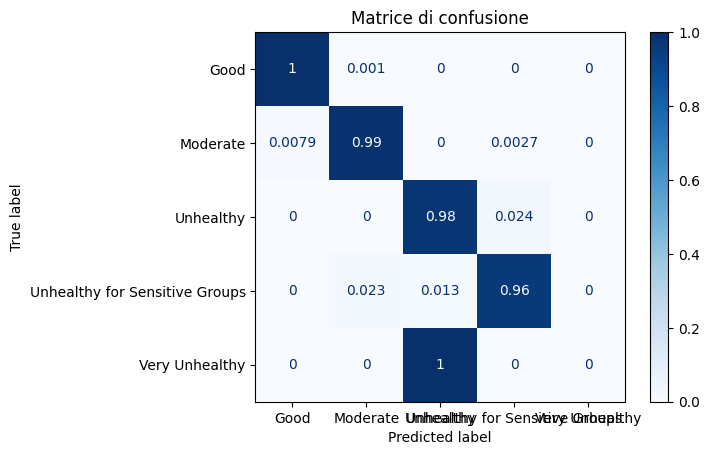

In [47]:
# Confrontiamo le classi reali dei dati di test con le classi predette dal modello per creare la matrice di confusione
# "normalize=True" fa in modo che i campi della matrice di confusione non siano corrispondenti al numero complessivo di casi ma che siano invece dei valori tra 0 e 1
cm= confusion_matrix(Y_test_encoded, Y_pred, normalize="true")
# Dobbiamo dire però alla funzione che visualizza la matrice di confusione come si chiamano le classi: lo facciamo nel parametro "display_labels" e gliele diciamo
# in ordine con la funzione sorted()
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(Y.unique()))
disp.plot(cmap='Blues') # Formattazione disegno
plt.title("Matrice di confusione") # Titolo disegno
plt.show()

**Visualizziamo l'andamento del loss durante le epoche di addestramento del modello**

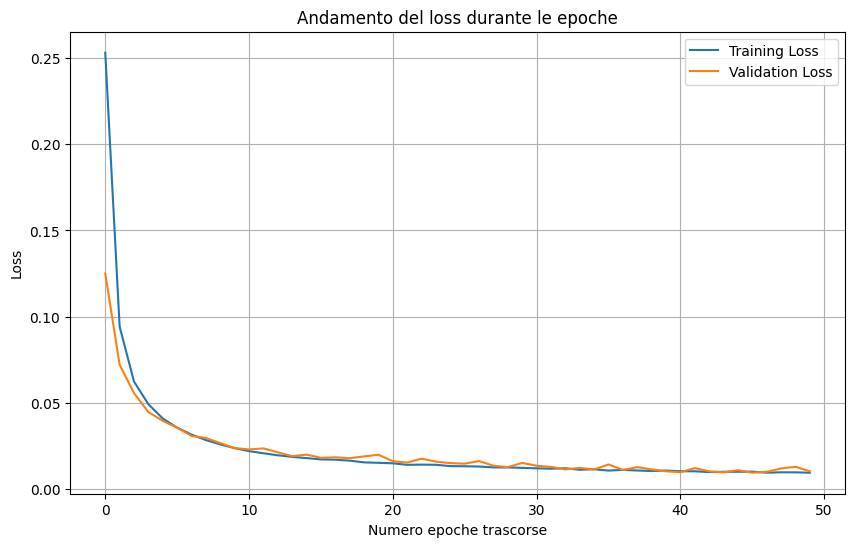

In [ ]:
# Usiamo Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss') # Disegnamo il grafico dell'andamento del loss calcolato sui dati di train
plt.plot(history.history['val_loss'], label='Validation Loss') # Disegnamo il grafico dell'andamento del loss calcolato sui dati di validation
plt.title('Andamento del loss durante le epoche')
plt.xlabel('Numero epoche trascorse')
plt.ylabel('Loss')
plt.legend() # Mostra la legenda
plt.grid(True) # Formattazione disegno
plt.show()

#se oltre una certa epoca la validation Loss si Apre, vuol dire che va in overfitting il modello (facendo fatica a generalizzare),ù
# ecco che occorre riaddestarre modificato le epoche mettendo il numero fino a quando vallitazion loss rimane vicina

**Visualizziamo l'andamento dell'accuracy durante le epoche di addestramento del modello**

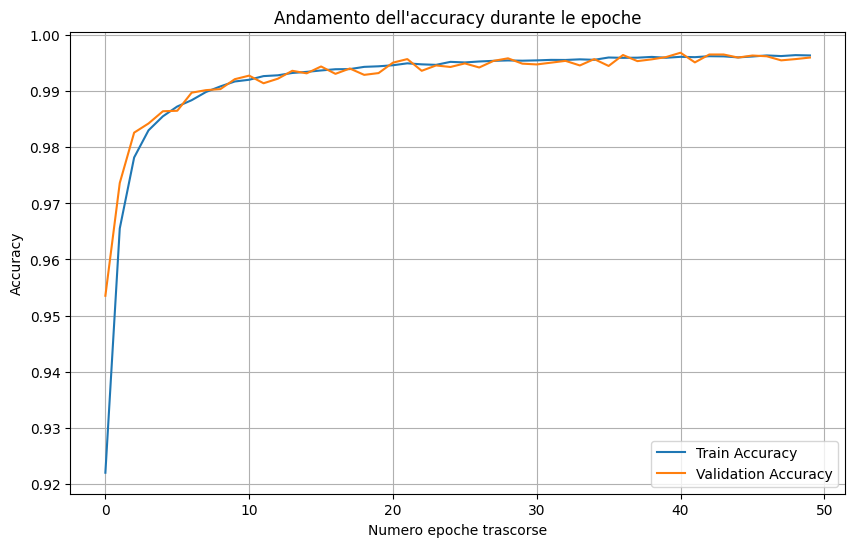

In [49]:
# Visualization of the validation accuracy trend
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy') # Disegnamo il grafico dell'andamento dell'accuracy calcolato sui dati di train
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Disegnamo il grafico dell'andamento dell'accuracy calcolato sui dati di validation
plt.title('Andamento dell\'accuracy durante le epoche')
plt.xlabel('Numero epoche trascorse')
plt.ylabel('Accuracy')
plt.legend() # Mostra la legenda
plt.grid(True) # Formattazione disegno
plt.show()